In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import KFold

In [27]:
head = ['user id', 'item id', 'rating', 'timestamp']
df_movies = pd.read_csv('ml-100k/u.data', sep='\t', names=head)

In [28]:
df_movies

,user id,item id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596
...,...,...,...,...
99995,880,476,3,880175444
99996,716,204,5,879795543
99997,276,1090,1,874795795
99998,13,225,2,882399156


In [29]:
def create_R_matrix(df_movies, n_users, n_items):
    R = pd.DataFrame(index=np.arange(1, n_items+1), columns=np.arange(1, n_users+1))
    groups = df_movies.groupby('user id')
    for name, group in groups:
        movies_rated = group['item id'].unique()
        R.loc[movies_rated, name] = group['rating'].values
    R = R.fillna(0)
    return(R.values)

On sépare notre matrice en un train set et un test set

In [30]:
train_set, test_set = train_test_split(df_movies, test_size = 0.1)

In [31]:
test_set

,user id,item id,rating,timestamp
9460,60,660,4,883327243
56017,255,872,4,883215723
1464,11,723,5,891904637
70088,724,286,1,883758268
69957,514,209,3,876062951
...,...,...,...,...
28706,339,735,4,891034717
18192,431,538,4,881127620
57421,354,496,3,891217109
20447,313,768,3,891030367


In [ ]:
test_set = pd.read_csv('ml_test.csv')
train_set = pd.read_csv('ml_train.csv')

In [ ]:
train_set

<h1>Descente de gradient stochastique</h1>

In [8]:
class SGD:
    def __init__(self, k, nb_users, nb_items, nb_iter=1000, mu = 0.2, lambda_ = 0.2, eta = 0.0005, zeta = 0.0005, eps = 0.1):
        self.k_components = k
        self.nb_iterations = nb_iter
        self.nb_users = nb_users
        self.nb_items = nb_items
        self.mu = mu
        self.lambda_ = lambda_
        self.eta = eta
        self.zeta = zeta
        self.eps = eps
        self.I = 2*np.random.random((self.nb_items, self.k_components))-1.0
        self.U = 2*np.random.random((self.nb_users, self.k_components))-1.0
        
    def cost(self, R, ITI, UTU):
        return(np.trace(np.dot(R.T, R)) - 2*np.trace(np.dot(R.T, np.dot(self.I, self.U.T))) + np.trace(np.dot(self.U, np.dot(ITI, self.U.T))) + self.lambda_*np.trace(UTU) + self.mu*np.trace(ITI))
    
    def fit(self, X):
        R = create_R_matrix(X, self.nb_users, self.nb_items)
        compt = 0
        ITI = np.dot(self.I.T, self.I)
        UTU = np.dot(self.U.T, self.U)
        tempI = self.I
        tempU = self.U
        while compt<self.nb_iterations: #self.cost(R, ITI, UTU)>self.eps and compt<self.nb_iterations:
            compt+=1
            tempI += -self.eta*(-2*np.dot(R, self.U) + 2*np.dot(self.I, UTU) + 2*self.lambda_*self.I)
            tempU += -self.zeta*(-2*np.dot(R.T, self.I) + 2*np.dot(self.U, ITI) + 2*self.mu*self.U)
            self.I = tempI
            self.U = tempU
            ITI = np.dot(self.I.T, self.I)
            UTU = np.dot(self.U.T, self.U)
        print(self.cost(R, ITI, UTU))
    
    def predict(self, X):
        y = []
        #print(X.apply(lambda x: self.U[x['user id']-1].dot(self.I[x['item id']-1]), axis=1))
        for x in X.iterrows():
            y.append(np.dot(self.U[x[1]['user id']-1], self.I[x[1]['item id']-1]))
        return(y)

In [8]:
n_users = (df_movies['user id'].unique())
print(len(n_users))
print(len(df_movies['user id']))

943
100000


In [90]:
model = SGD(k=10, nb_users=943, nb_items=1682, nb_iter=300)
model.fit(train_set)

678268.8901339602


In [104]:
preds = model.predict(test_set)
print(mean_squared_error(test_set['rating'].values, preds, squared=False))

2.6278728268507328
-4.422088932559568


In [105]:
kf = KFold(n_splits=5, shuffle=True, random_state = 4)
rmse = []
for train_index, test_index in kf.split(df_movies):
    train_set = df_movies.loc[train_index]
    test_set = df_movies.loc[test_index]
    model = SGD(k=10, nb_users=943, nb_items=1682, nb_iter=150)
    model.fit(train_set)
    preds = model.predict(test_set)
    rmse.append(mean_squared_error(test_set['rating'].values, preds, squared=False))

685744.1012902217
680843.7260820094
681347.2999430103
683291.2779672997
685284.68264946


In [107]:
print(np.mean(rmse))

2.6326069925510085
-4.470652157006732
[-4.552715098274008, -4.543640687259528, -4.342263038931784, -4.424633631879427, -4.490008328688915]


### Test sur différents paramètres

#### Variation du rang k - rmse

In [9]:
K = [1, 2, 5, 10, 20, 30, 40, 50]

In [41]:
Rmse_SGD_K = []
kf = KFold(n_splits=5, shuffle=True, random_state = 4)
for k in K:
    print('k =',k)
    rmse = []
    for train_index, test_index in kf.split(df_movies):
        train_set = df_movies.loc[train_index]
        test_set = df_movies.loc[test_index]
        model = SGD(k=k, nb_users=943, nb_items=1682, nb_iter=300)
        model.fit(train_set)
        preds = model.predict(test_set)
        rmse.append(mean_squared_error(test_set['rating'].values, preds, squared=False))
    Rmse_SGD_K.append(np.mean(rmse))

k = 1
836620.4730425075
833394.2493160729
833808.9780878666
834452.299284118
834239.1840020199
k = 2
797531.2422114621
794060.5606416898
794396.6510281904
795452.6570563564
795085.9224585494
k = 5
732174.4815440715
729322.0111806177
730288.4053861327
730245.865828369
729522.111412811
k = 10
680921.7541500262
678370.867145894
678971.7117722208
678486.5899151864
678435.4383731518
k = 20
626391.3107689671
624476.7803695842
625602.523532808
625771.7731733898
623466.1993272037
k = 30
585052.4939524768
581361.5210652546
582778.8373807714
582678.3648836723
580964.9913269773
k = 40
549392.075960918
543723.2354922005
547501.9859315584
546497.6313780907
545044.544525746
k = 50
516003.8186910057
512474.3525148123
514214.2423620443
512790.47425308125
514192.7552930693


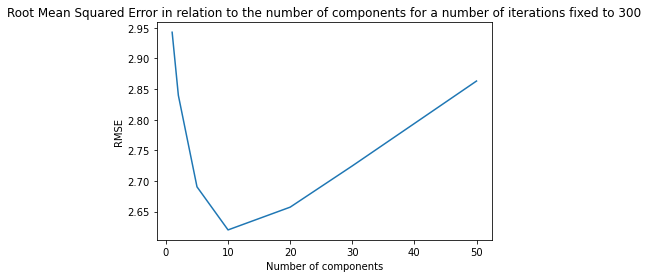

In [43]:
plt.plot(K, Rmse_SGD_K)
plt.xlabel('Number of components')
plt.ylabel('RMSE')
plt.title('Root Mean Squared Error in relation to the number of components for a number of iterations fixed to 300')
plt.show()

#### Variation du nombre d'itération par rapport à rmse pour k fixé à 10 (since best k possible)

In [14]:
Nb_iter = [10, 50, 150, 300, 500]

In [15]:
Rmse_SGD_Nb_iter = []
kf = KFold(n_splits=5, shuffle=True, random_state = 4)
for nb_iter in Nb_iter:
    print('nb_iter =',nb_iter)
    rmse = []
    for train_index, test_index in kf.split(df_movies):
        train_set = df_movies.loc[train_index]
        test_set = df_movies.loc[test_index]
        model = SGD(k=10, nb_users=943, nb_items=1682, nb_iter=nb_iter)
        model.fit(train_set)
        preds = model.predict(test_set)
        rmse.append(mean_squared_error(test_set['rating'].values, preds, squared=False))
    Rmse_SGD_Nb_iter.append(np.mean(rmse))

nb_iter = 10
860519.8324490829
834911.30385435
835351.1224371545
833745.9575184028
837311.9076523803
nb_iter = 50
735587.6891209895
727078.1900873738
731375.0910278264
726004.3618353582
729178.9458906302
nb_iter = 150
685331.4300264844
680596.5987679043
681328.1524025071
682558.9973636008
681271.305755524
nb_iter = 300
681119.9984368914
677829.3686849216
679603.1323558507
679541.43974924
678716.6367793082
nb_iter = 500
681058.2403873276
677304.064680691
679336.9697226471
678005.095722025
677828.1042856156


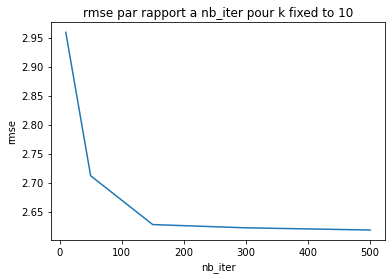

In [68]:
plt.plot(Nb_iter, Rmse_SGD_Nb_iter)
plt.xlabel('nb_iter')
plt.ylabel('RMSE')
plt.title('RMSE par rapport a nb_iter pour k fixed to 10')
plt.show()

# Alternated least square

In [32]:
class ALS:
    def __init__(self, k, nb_users, nb_items, nb_iter=1000, mu = 0.1, lambda_ = 0.1, eps = 0.1):
        self.k_components = k
        self.nb_iterations = nb_iter
        self.nb_users = nb_users
        self.nb_items = nb_items
        self.mu = mu
        self.lambda_ = lambda_
        self.eps = eps
        self.I = np.random.random((self.nb_items, self.k_components))
        self.U = np.random.random((self.nb_users, self.k_components))
        
    def cost(self, R, ITI, UTU):
        return(np.trace(np.dot(R.T, R)) - 2*np.trace(np.dot(R.T, np.dot(self.I, self.U.T))) + np.trace(np.dot(self.U, np.dot(ITI, self.U.T))) + self.lambda_*np.trace(UTU) + self.mu*np.trace(ITI))
    
    def fit(self, X):
        R = create_R_matrix(X, self.nb_users, self.nb_items)
        compt = 0
        ITI = np.dot(self.I.T, self.I)
        UTU = np.dot(self.U.T, self.U)
        while compt<self.nb_iterations: #self.cost(R, ITI, UTU)>self.eps and compt<self.nb_iterations:
            compt+=1
            self.I = np.dot(R, np.dot(self.U, np.linalg.inv(UTU + self.lambda_*np.eye(self.k_components))))
            self.U = np.dot(R.T, np.dot(self.I, np.linalg.inv(ITI + self.mu*np.eye(self.k_components))))
            ITI = np.dot(self.I.T, self.I)
            UTU = np.dot(self.U.T, self.U)
        print(self.cost(R, ITI, UTU))
    
    def predict(self, X):
        y = []
        #print(X.apply(lambda x: self.U[x['user id']-1].dot(self.I[x['item id']-1]), axis=1))
        for x in X.iterrows():
            y.append(np.dot(self.U[x[1]['user id']-1], self.I[x[1]['item id']-1]))
        return(y)

In [109]:
train_set, test_set = train_test_split(df_movies, test_size = 0.2)

model = ALS(k=40, nb_users=943, nb_items=1682, nb_iter=700)
model.fit(train_set)

2164483.076752121


In [110]:
preds = model.predict(test_set)
print(mean_squared_error(test_set['rating'].values, preds, squared=False))

2.8273064992264856


In [111]:
kf = KFold(n_splits=5, shuffle=True, random_state = 4)
rmse = []
for train_index, test_index in kf.split(df_movies):
    train_set = df_movies.loc[train_index]
    test_set = df_movies.loc[test_index]
    model = ALS(k=40, nb_users=943, nb_items=1682, nb_iter=700)
    model.fit(train_set)
    preds = model.predict(test_set)
    rmse.append(mean_squared_error(test_set['rating'].values, preds, squared=False))

2128316.091396766
2446481.6632584124
2222819.9306274103
2342637.2966812775
2473246.476500117


In [112]:
print(np.mean(rmse))

2.8551909621381055


### Tests sur différents paramètres

#### Variation du rang k - rmse


In [33]:
K = [1, 2, 5, 10, 20, 30, 40, 50]

In [40]:
Rmse_ALS_K = []
kf = KFold(n_splits=5, shuffle=True, random_state = 4)
for k in K:
    print('k =',k)
    rmse = []
    for train_index, test_index in kf.split(df_movies):
        train_set = df_movies.loc[train_index]
        test_set = df_movies.loc[test_index]
        model = ALS(k=k, nb_users=943, nb_items=1682, nb_iter=300)
        model.fit(train_set)
        preds = model.predict(test_set)
        rmse.append(mean_squared_error(test_set['rating'].values, preds, squared=False))
    Rmse_ALS_K.append(np.mean(rmse))

k = 1
1217827.1212274136
1096865.9998680453
3489936.6458747694
1098731.7314616095
1188023.8465815864
k = 2
190471173071301.7
1095945.4590501795
2580078618.0720162
2469053091856.378
1085776.805956722
k = 5
1033498.7223251769
2.961733829033753e+18
2634933989381671.5
9951337470251.016
1103061994963407.9
k = 10
4.89854459623325e+16
932337292274975.9
646117532692.4119
1292576535257741.0
1471782373912.6506
k = 20
1734140598964.923
7860397380465951.0
440451479035684.25
6615635050609544.0
4582075009486604.0
k = 30
60689935046522.4
2186064488340051.8
291841956717211.6
824070303150543.9
667457681491121.6
k = 40
154125802619534.84
598960527113406.4
85500386196331.5
680287479965610.2
20575058405206.09
k = 50
430363012171718.94
406462266500766.1
235496020554965.28
4186053673130902.5
160312835870442.44


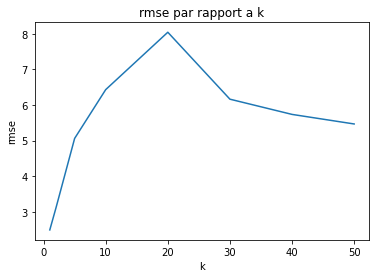

In [115]:
plt.plot(K, Rmse_ALS_K)
plt.xlabel('k')
plt.ylabel('rmse')
plt.title('rmse par rapport a k')
plt.show()

#### Variation du nombre d'itération par rapport à rmse pour k fixé à 10 (since best k possible)

In [19]:
Nb_iter = [10, 50, 150, 300, 500]

In [20]:
Rmse_ALS_Nb_iter = []
kf = KFold(n_splits=5, shuffle=True, random_state = 4)
for nb_iter in Nb_iter:
    print('nb_iter =',nb_iter)
    rmse = []
    for train_index, test_index in kf.split(df_movies):
        train_set = df_movies.loc[train_index]
        test_set = df_movies.loc[test_index]
        model = ALS(k=40, nb_users=943, nb_items=1682, nb_iter=nb_iter)
        model.fit(train_set)
        preds = model.predict(test_set)
        rmse.append(mean_squared_error(test_set['rating'].values, preds, squared=False))
    Rmse_ALS_Nb_iter.append(np.mean(rmse))

nb_iter = 10
182139415.91023988
210651504.72401035
194344872.1410095
185971453.00158125
203401958.4116392
nb_iter = 50
60979810.15188656
49431045.189575434
52201043.47406931
51900993.98095018
58756963.46046884
nb_iter = 150
14697306.29275569
15226331.158295507
12526660.977940556
13346530.182839511
15362843.384194475
nb_iter = 300
6684781.255205562
9571479.830242641
6381497.538941275
4911991.637153447
7063854.638097139
nb_iter = 500
3716607.7705389955
3565142.094775755
3775763.714390378
3359943.2425492364
3368236.9268625756


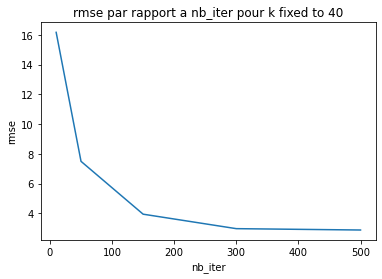

In [73]:
plt.plot(Nb_iter, Rmse_ALS_Nb_iter)
plt.xlabel('nb_iter')
plt.ylabel('rmse')
plt.title('rmse par rapport a nb_iter pour k fixed to 40')
plt.show()

### Comparaison courbes RMSE pr Nb_iter et K

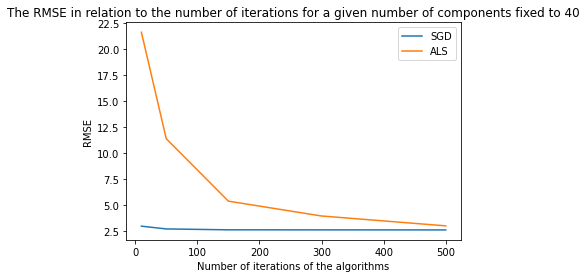

In [21]:
plt.plot(Nb_iter, Rmse_SGD_Nb_iter, label='SGD')
plt.plot(Nb_iter, Rmse_ALS_Nb_iter, label='ALS')
plt.xlabel('Number of iterations of the algorithms')
plt.ylabel('RMSE')
plt.title('The RMSE in relation to the number of iterations for a given number of components fixed to 40')
plt.legend()
plt.show()

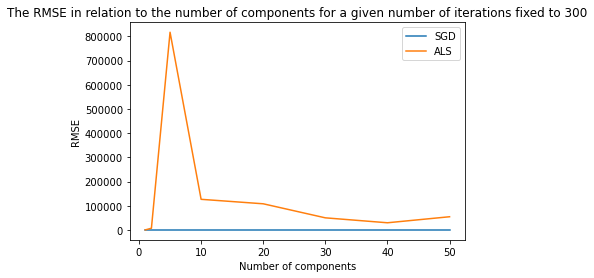

In [42]:
plt.plot(K, Rmse_SGD_K, label='SGD')
plt.plot(K, Rmse_ALS_K, label='ALS')
plt.xlabel('Number of components')
plt.ylabel('RMSE')
plt.title('The RMSE in relation to the number of components for a given number of iterations fixed to 300')
plt.legend()
plt.show()

<h1>ALS avec les zéros manquants</h1>

### TEST AVEC DES MASQUES

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import KFold

In [36]:
head = ['user id', 'item id', 'rating', 'timestamp']
df_movies = pd.read_csv('ml-100k/u.data', sep='\t', names=head)

In [37]:
def create_R_matrix(df_movies, n_users, n_items):
    R = pd.DataFrame(index=np.arange(1, n_items+1), columns=np.arange(1, n_users+1))
    groups = df_movies.groupby('user id')
    for name, group in groups:
        movies_rated = group['item id'].unique()
        R.loc[movies_rated, name] = group['rating'].values
    R = R.fillna(0)
    return(R.values)

In [124]:
train_set, test_set = train_test_split(df_movies, test_size = 0.1)
test_set

,user id,item id,rating,timestamp
84039,174,167,3,886514953
57532,655,662,2,888686011
84102,543,324,3,890723992
1753,275,69,3,880314089
65413,881,434,2,876538889
...,...,...,...,...
83587,896,234,4,887157925
33498,105,327,4,889214406
84399,834,15,4,890863052
56111,798,563,2,875638323


In [133]:
class ALS_MV:
    def __init__(self, k, nb_users, nb_items, nb_iter=1000, eps = 0.1):
        self.k_components = k
        self.nb_iterations = nb_iter
        self.nb_users = nb_users
        self.nb_items = nb_items
        self.eps = eps
        self.I = np.random.random((self.nb_items, self.k_components))
        self.U = np.random.random((self.nb_users, self.k_components))
        
    def cost(self, R, I, U):
        mask = pd.DataFrame(R).notnull().values
        IU = np.dot(I, U.T)
        IU_mask = IU[mask]    
        R_mask = R.values[mask]
        R_IU_mask = R_mask-IU_mask
        
        # Since now R_IU_mask is a vector, we use L2 instead of Frobenius norm for matrix
        return np.linalg.norm(R_IU_mask, 2)
    
    def fit(self, X):
        from scipy.optimize import lsq_linear
        
        R = create_R_matrix(X, self.nb_users, self.nb_items)
        R = pd.DataFrame(R, index=np.arange(1, self.nb_items+1), columns=np.arange(1, self.nb_users+1))
        R = R.replace(0, np.nan)
        i = 0

        tempI = self.I
        tempU = self.U
        
        while i < self.nb_iterations: 
            if i%2 == 0:
                # Learn tempU, given R and tempI
                for j in range(R.shape[1]):
                    mask = R.iloc[:,j].notnull()
                    R_mask = R.iloc[:,j][mask]
                    tempI_mask = tempI[mask]
                    #print("TempI_mask shape ", tempI_mask.shape)
                    
                    tempU.transpose()[:,j] = lsq_linear(tempI_mask, R_mask).x
            
            else:
                # Learn tempI, given R and tempU
                for j in range(R.shape[0]):
                    mask = R.iloc[j,:].notnull()
                    R_mask = R.iloc[j,:][mask]
                    #print("R_mask shape ", R_mask.shape)
                    tempU_mask = tempU[mask]
                    #print("TempU_mask shape ", tempU_mask.shape)
                    
                    tempI[j,:] = lsq_linear(tempU_mask, R_mask).x

            c = self.cost(R, tempI, tempU)
            print(i, c)
            i+=1
            
        self.I = tempI
        self.U = tempU
        #print("Shape I", self.I.shape)
        #print("Shape U", self.U.shape)
        
    
    def predict(self, X):
        y = []
        for x in X.iterrows():
            y.append(np.dot(self.I[x[1]['item id']-1], self.U[x[1]['user id']-1]))
        return(y)

In [127]:
model = ALS_MV(k=5, nb_users=943, nb_items=1682, nb_iter=10)
model.fit(train_set)

0 393.69745138936656
1 266.9915077029457
2 257.36903683747977
3 253.4961448981296
4 251.21085560847018
5 249.35729821900642
6 247.74002391192118
7 246.27220849775838
8 244.94197556145915
9 243.75703406362624
Shape I (1682, 5)
Shape U (943, 5)


In [129]:
R_preds = model.predict(test_set)
print(mean_squared_error(test_set['rating'].values, R_preds, squared=False))

1.5072317416151393


### Plots

In [134]:
K = [1, 2, 5, 10, 20, 30, 40, 50]

In [135]:
Rmse_ALS_MV_K = []
kf = KFold(n_splits=5, shuffle=True, random_state = 4)
for k in K:
    print('k =',k)
    rmse = []
    for train_index, test_index in kf.split(df_movies):
        train_set = df_movies.loc[train_index]
        test_set = df_movies.loc[test_index]
        model = ALS_MV(k=k, nb_users=943, nb_items=1682, nb_iter=50)
        model.fit(train_set)
        preds = model.predict(test_set)
        rmse.append(mean_squared_error(test_set['rating'].values, preds, squared=False))
    Rmse_ALS_MV_K.append(np.mean(rmse))

k = 1
0 584.9335251819459
1 266.61429144029483
2 259.6165004665432
3 258.8760939415678
4 258.7521800609622
5 258.7285868867688
6 258.72375627292973
7 258.7226997299603
8 258.7224494388152
9 258.72238373413785
10 258.7223643091543
11 258.7223578592233
12 258.7223555059901
13 258.7223545898671
14 258.72235421860813
15 258.7223540646474
16 258.7223539999712
17 258.7223539726102
18 258.7223539609904
19 258.72235395604525
20 258.7223539539382
21 258.7223539530398
22 258.7223539526567
23 258.7223539524932
24 258.72235395242353
25 258.72235395239375
26 258.72235395238107
27 258.72235395237567
28 258.72235395237334
29 258.7223539523723
30 258.72235395237186
31 258.72235395237175
32 258.7223539523717
33 258.7223539523717
34 258.72235395237163
35 258.72235395237163
36 258.72235395237163
37 258.72235395237163
38 258.72235395237163
39 258.72235395237163
40 258.72235395237163
41 258.7223539523716
42 258.72235395237163
43 258.72235395237163
44 258.72235395237163
45 258.72235395237163
46 258.72235395

36 243.3077723054092
37 243.30162085368957
38 243.29560763395565
39 243.2899387449412
40 243.28373977620896
41 243.27752643086174
42 243.27043013694927
43 243.26298423221306
44 243.24979292645187
45 243.23818047606247
46 243.23023846231627
47 243.22407808852307
48 243.218180451445
49 243.21231234621933
0 491.45479954148226
1 263.2236488870214
2 253.72733998128604
3 251.50233805519778
4 250.55119951064907
5 249.9607729092171
6 249.5289401460184
7 249.17386595665096
8 248.88044275920402
9 248.63038217747936
10 248.41113657364153
11 248.20773842890603
12 248.01291105402112
13 247.81545427078726
14 247.61043262083572
15 247.38482525462805
16 247.13289940681616
17 246.87588418010716
18 246.62612153336647
19 246.38692217050146
20 246.1550964091884
21 245.93260223065178
22 245.72374424474356
23 245.53399522654564
24 245.36784317687668
25 245.2237975882374
26 245.10301602037467
27 244.99890336812814
28 244.9099575594669
29 244.83071752848238
30 244.75956560370432
31 244.6983952953764
32 244.64

18 193.63628252267708
19 193.29763152504148
20 192.98418024885297
21 192.69336407636288
22 192.41575961338515
23 192.15587922186793
24 191.9110622576599
25 191.68603927655695
26 191.4750558711204
27 191.27841327253196
28 191.09068230606064
29 190.91360110325076
30 190.74392370904602
31 190.58267684053712
32 190.4273594780117
33 190.2787620963323
34 190.13571567807026
35 189.9989992245863
36 189.86539395407496
37 189.73711236118572
38 189.6114981332355
39 189.48698718622308
40 189.3678400114795
41 189.25508814839554
42 189.1431684242139
43 189.03574839167214
44 188.92413151690073
45 188.81877179441702
46 188.71542354342208
47 188.6170295528294
48 188.52119781945643
49 188.4290417400624
0 316.8987743539997
1 231.54855955058233
2 218.38750659619643
3 211.9328020144109
4 208.06125972388804
5 205.2805113208063
6 203.1635228106466
7 201.48482642704116
8 200.09078013024188
9 198.93299066337067
10 197.93762495555674
11 197.08363525893242
12 196.3294480703113
13 195.67838385464083
14 195.100014

0 279.1609864170168
1 202.34104671163666
2 187.1233538878626
3 178.72767398423613
4 173.5074089785696
5 169.55747299187362
6 166.5533342818382
7 164.08657631897643
8 162.02090886628645
9 160.26740288049487
10 158.73704857616252
11 157.39689147860273
12 156.22282825055277
13 155.18617003758104
14 154.2614431823479
15 153.42039571488667
16 152.66317129628823
17 151.97151720339156
18 151.34249523271342
19 150.75790330257507
20 150.21979850190485
21 149.71368250795274
22 149.24613377397984
23 148.80284129958827
24 148.38950710103492
25 148.00262712046842
26 147.63992652803765
27 147.2956637560904
28 146.97124267585005
29 146.66334615116793
30 146.37235377508028
31 146.09556907132853
32 145.83116963147165
33 145.57876883833677
34 145.33734002832563
35 145.10508782706427
36 144.87983248106005
37 144.66213825080422
38 144.4530805089402
39 144.25164928091215
40 144.0569824356274
41 143.8692887947178
42 143.68817148786022
43 143.51377249045171
44 143.34509962916079
45 143.18209558027849
46 143.

31 83.84351238421927
32 83.44750532379896
33 83.07115639381078
34 82.7122394055963
35 82.36778287645409
36 82.03849537873721
37 81.72305222293754
38 81.41997313632483
39 81.12833556799349
40 80.84649805076647
41 80.5740402248115
42 80.31176170877185
43 80.05772538159306
44 79.81337581018754
45 79.57638625467445
46 79.34781752225643
47 79.12620286184976
48 78.91178805301084
49 78.70334016390909
0 240.27403698233064
1 156.9889051620512
2 139.05585284928503
3 127.99008333190068
4 121.0286684421193
5 115.74575245610252
6 111.74531568750147
7 108.38000356275452
8 105.60628955639615
9 103.17701869175896
10 101.10182680337921
11 99.26663804001339
12 97.65231033624951
13 96.19162641447764
14 94.87784275041625
15 93.68785388813528
16 92.60782324344089
17 91.60987663786524
18 90.6937448408899
19 89.83684054251226
20 89.04507890270757
21 88.29754274674184
22 87.60273197945128
23 86.93996177432702
24 86.32154799268967
25 85.73511782184171
26 85.18076704568882
27 84.65117981435313
28 84.14995446943

23 62.72440841697799
24 62.05951058405594
25 61.432318448395726
26 60.83987171958663
27 60.27763462915007
28 59.74410224202346
29 59.23635683264109
30 58.753665857826434
31 58.29217952497404
32 57.850852987446835
33 57.42826545175814
34 57.02530299891385
35 56.637776386683626
36 56.265057822527716
37 55.90611084637005
38 55.56187736502708
39 55.229305353659846
40 54.90866253726128
41 54.59846201611524
42 54.300064753887526
43 54.01068232198504
44 53.73148254293104
45 53.46019524251176
46 53.198032373624855
47 52.9431086762642
48 52.69667359878672
49 52.456415079217486
0 222.73823451306964
1 137.8724542925009
2 119.50322047311069
3 107.82672032053163
4 100.63054422221047
5 95.03633826937802
6 90.75348319267216
7 87.20087832148448
8 84.25071710972537
9 81.71527702709521
10 79.52359216532453
11 77.5745008129169
12 75.86728803259021
13 74.3278038102808
14 72.95600526975714
15 71.70131826223333
16 70.56894113621928
17 69.52400394386937
18 68.55394600226138
19 67.64892099147848
20 66.8054884

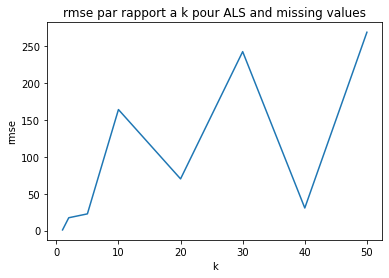

In [137]:
plt.plot(K, Rmse_ALS_MV_K)
plt.xlabel('k')
plt.ylabel('rmse')
plt.title('rmse par rapport a k pour ALS and missing values')
plt.show()

In [146]:
Nb_iter = [10, 50, 150, 300, 500]

In [147]:
Rmse_ALS_MV_Nb_iter = []
kf = KFold(n_splits=5, shuffle=True, random_state = 4)
for nb_iter in Nb_iter:
    print('nb_iter =',nb_iter)
    rmse = []
    for train_index, test_index in kf.split(df_movies):
        train_set = df_movies.loc[train_index]
        test_set = df_movies.loc[test_index]
        model = ALS_MV(k=40, nb_users=943, nb_items=1682, nb_iter=nb_iter)
        model.fit(train_set)
        preds = model.predict(test_set)
        rmse.append(mean_squared_error(test_set['rating'].values, preds, squared=False))
    Rmse_ALS_MV_Nb_iter.append(np.mean(rmse))

nb_iter = 10
0 238.602037171066
1 157.76459909701146
2 139.84156235354286
3 128.78391462542265
4 121.8289952721387
5 116.47721445729901
6 112.4232757265417
7 109.08216981745443
8 106.3406651164402
9 103.98360638525779
0 237.85453514671983
1 156.5689643633078
2 139.2302602407116
3 128.3521218733431
4 121.54147406655522
5 116.36840262304993
6 112.33419757360623
7 108.94077883179226
8 106.12667942800527
9 103.67010744821513
0 240.09065597424552
1 156.93765714777777
2 139.26840534600078
3 128.3157861179173
4 121.4421974675235
5 116.10148278370266
6 111.97149938062833
7 108.53297715304976
8 105.70817961496395
9 103.2843959584711
0 235.87016478363554
1 154.96221781335456
2 137.37715762708328
3 126.48753098149263
4 119.64102561101288
5 114.45873028116877
6 110.51157430594144
7 107.31163198802344
8 104.68935272759256
9 102.42553612621711
0 237.15084109851395
1 156.26569844729192
2 138.37264199663045
3 127.13930234777308
4 120.02663707300584
5 114.5845320550951
6 110.48658089840384
7 107.125333

92 72.3692353133447
93 72.28139057944662
94 72.19495647460289
95 72.10967736082762
96 72.02570109610211
97 71.94282594358361
98 71.86114523096965
99 71.78044795778221
100 71.70096963647715
101 71.6224155844
102 71.54504181236983
103 71.46855660846141
104 71.39317487286849
105 71.31844847236148
106 71.24466271605114
107 71.16146007598162
108 71.08545562255081
109 71.01169687400022
110 70.93950407872104
111 70.86861945448054
112 70.7988293343193
113 70.72976271561589
114 70.66172577484907
115 70.59468003728202
116 70.52733701204296
117 70.4613676105768
118 70.39633666049262
119 70.33225952622008
120 70.26895221139435
121 70.2064505608459
122 70.14468361597608
123 70.08372761071027
124 70.02343862703151
125 69.9637572495944
126 69.90478015628919
127 69.84651399686726
128 69.78886054571532
129 69.73181885579322
130 69.67539677014943
131 69.61954065810933
132 69.56424159336001
133 69.50960646631252
134 69.45549386135464
135 69.40195935311463
136 69.34888083779434
137 69.29640590651847
138 6

29 84.4630444215204
30 84.02234897311186
31 83.600110277758
32 83.19504778764009
33 82.80326614676534
34 82.42449859421248
35 82.05814236521448
36 81.70235494896079
37 81.3585987838169
38 81.02373535231138
39 80.70012343686523
40 80.38883594748361
41 80.08755512575193
42 79.79461415228792
43 79.51128104429813
44 79.2404967383836
45 78.97800597713022
46 78.72101528760612
47 78.47403389193826
48 78.23619817331712
49 78.00331374620264
50 77.77983772834173
51 77.56104067419821
52 77.35030549665781
53 77.14598696154106
54 76.9486806067318
55 76.7565055535628
56 76.57047790255179
57 76.38919988160477
58 76.212921066296
59 76.0407905792153
60 75.87340425729423
61 75.71011410954128
62 75.55088964005034
63 75.39508390074688
64 75.24280275954246
65 75.09400476349465
66 74.94525166142695
67 74.80110382265
68 74.66069961644406
69 74.52299312155341
70 74.38866216912243
71 74.25671455944011
72 74.12770873431155
73 74.00082858973654
74 73.87666023035689
75 73.75439635327326
76 73.63395081021484
77 73

116 70.94133151359881
117 70.8750327722145
118 70.80939883362964
119 70.74443699903705
120 70.6801488997758
121 70.61614807438767
122 70.5527627941607
123 70.4902007107158
124 70.42819608670666
125 70.366863618896
126 70.3054516405694
127 70.24494542651821
128 70.18510168921767
129 70.12587776047135
130 70.06723700931136
131 70.00914637433743
132 69.95161345674312
133 69.89460234310661
134 69.83817165277372
135 69.7822359344933
136 69.72688589235995
137 69.67194565535092
138 69.61753840461901
139 69.56356383951244
140 69.51014476054786
141 69.45705370625721
142 69.4044962066856
143 69.35205799918941
144 69.3001852650252
145 69.24889497355544
146 69.1980846142654
147 69.14765878597213
148 69.09765149438611
149 69.04776154225218
150 68.99832324132834
151 68.94886419602882
152 68.90002732325561
153 68.85168840626118
154 68.80374443409202
155 68.75625059017085
156 68.70916809953847
157 68.66249351955572
158 68.61607463175056
159 68.5701404231106
160 68.5245649881749
161 68.47942379784098
1

196 65.90765134553662
197 65.87654127034004
198 65.8455661961573
199 65.81486323972811
200 65.78435503419698
201 65.75408213375887
202 65.72406154308725
203 65.69426444474026
204 65.66466118661731
205 65.63525818609472
206 65.6060644916522
207 65.57709432438939
208 65.54830495196998
209 65.51972073605064
210 65.4913242560965
211 65.46312905407933
212 65.43509702838368
213 65.40726091294178
214 65.37960235355328
215 65.3521302620331
216 65.32481264146253
217 65.29767242959144
218 65.27069939547097
219 65.2439064778876
220 65.21726013540719
221 65.19077633994216
222 65.16444545135083
223 65.13827757225658
224 65.11225467653445
225 65.08635764583141
226 65.06062453592087
227 65.03497226413481
228 65.00950666677102
229 64.98416422913758
230 64.95899291241443
231 64.93388629645278
232 64.90895564798166
233 64.88419991850645
234 64.85958089589037
235 64.83509453155676
236 64.8107315380535
237 64.78653641649609
238 64.76245851390748
239 64.73852837026367
240 64.714703505973
241 64.69103814924

276 64.6111933456542
277 64.59348747492763
278 64.57587117136879
279 64.55834234416241
280 64.54091574433755
281 64.52358852625319
282 64.50635225536472
283 64.48919792531092
284 64.47213690168712
285 64.45516829465952
286 64.43828723751324
287 64.42148664910106
288 64.40476461066801
289 64.38813272667278
290 64.37158660750477
291 64.35511623223647
292 64.33873036727884
293 64.32242435488304
294 64.30619890312323
295 64.29004646102402
296 64.27397492805244
297 64.25798123713439
298 64.24206665220274
299 64.22622147497891
0 236.92405706045923
1 155.4245826142515
2 138.05322814938546
3 127.42936150345491
4 120.6949344556287
5 115.51473035176896
6 111.5320107760734
7 108.18453465522833
8 105.376867991967
9 102.97061224303545
10 100.89056216808822
11 99.06992523507503
12 97.46719833414762
13 96.0381066111061
14 94.76829569144357
15 93.6104461256812
16 92.56681868173818
17 91.60426483525181
18 90.72362423998295
19 89.90629464424548
20 89.15147186344828
21 88.44479364076342
22 87.78617815786

58 75.85617255576221
59 75.69036547099977
60 75.52908258994395
61 75.37173879570972
62 75.21827134652146
63 75.06835471860876
64 74.9222862247517
65 74.77942758067776
66 74.63980702037486
67 74.50328763838061
68 74.36994812544663
69 74.2396910975186
70 74.11204477107319
71 73.98724674291468
72 73.8651115183364
73 73.74554676369179
74 73.62849902456577
75 73.51362665424143
76 73.40118621821253
77 73.29054707980207
78 73.18218780793623
79 73.07531866182845
80 72.97063075031255
81 72.86720696172509
82 72.76575713166815
83 72.66557467134658
84 72.5671847691642
85 72.47015856256596
86 72.37508186610245
87 72.28130155109021
88 72.1895537682275
89 72.09889554184662
90 72.01007101352918
91 71.92261250576145
92 71.83678196376059
93 71.7522852827421
94 71.66919840225124
95 71.5874371945282
96 71.50701033163917
97 71.42779741805951
98 71.34980199901683
99 71.2729482132685
100 71.19724528310012
101 71.12261596388039
102 71.04902507123259
103 70.97643902311009
104 70.90480953515886
105 70.833990280

141 69.59906729213125
142 69.55291671304511
143 69.50747159313069
144 69.46242723249539
145 69.41798602629876
146 69.37401620499898
147 69.33055559586973
148 69.2875232968268
149 69.24493058367293
150 69.2027448631302
151 69.16068517878259
152 69.11900907393195
153 69.0777630725479
154 69.03705079991376
155 68.99669304576936
156 68.95683852243262
157 68.91731109198601
158 68.87820947056652
159 68.83944139261781
160 68.80107192579372
161 68.76302754899666
162 68.72533889553573
163 68.68795608576438
164 68.6509114243946
165 68.61416363971857
166 68.57773380548412
167 68.53994712587377
168 68.50353970576519
169 68.46761591283986
170 68.4320887456129
171 68.39683819824572
172 68.36191533109142
173 68.32727681393789
174 68.29295760138596
175 68.25891537856167
176 68.22515658377104
177 68.1916131062717
178 68.15834990382257
179 68.12532806543358
180 68.09257369565942
181 68.06003835324933
182 68.02775727262586
183 67.99567242025343
184 67.96383130105144
185 67.93218459385538
186 67.900769810

15 94.04571416801409
16 92.98941321621355
17 92.01946114390675
18 91.1136488613122
19 90.27497124976188
20 89.49047399940804
21 88.75377134986442
22 88.06144766158468
23 87.40847214292656
24 86.78962114308491
25 86.2060977487209
26 85.64851013366851
27 85.12029315562265
28 84.61772762254498
29 84.13975084569175
30 83.68479355706694
31 83.25025590514731
32 82.83529707048034
33 82.43438128936485
34 82.05455028415876
35 81.6883545923728
36 81.34017575783581
37 81.00254026762265
38 80.68110856722474
39 80.37268560680768
40 80.07662898112109
41 79.79171052892234
42 79.51613063901166
43 79.25027067652654
44 78.99375667938658
45 78.74643600912471
46 78.50614069326323
47 78.27447577570315
48 78.04939755767776
49 77.83183324074557
50 77.62047654210558
51 77.41561690491608
52 77.2159823193662
53 77.02231518065697
54 76.83321787500311
55 76.64954391492745
56 76.46972674578534
57 76.29499685824838
58 76.12393569654033
59 75.95764250004875
60 75.79532159227904
61 75.63714746287854
62 75.48261579939

394 63.52567493805634
395 63.51592174297295
396 63.50623262853034
397 63.49628549609209
398 63.48645076035615
399 63.476043710951686
400 63.46589148304833
401 63.454924817917664
402 63.44447002112096
403 63.43345786865916
404 63.4230138637018
405 63.41238912167929
406 63.40210630245762
407 63.39182144742726
408 63.38176530888527
409 63.37131075202353
410 63.36141262152023
411 63.35173932815256
412 63.34218458832117
413 63.33272472691145
414 63.32334845000266
415 63.314047220061816
416 63.30481211853798
417 63.295633270034514
418 63.286509747355254
419 63.27744025294512
420 63.26842032765415
421 63.259438799799135
422 63.25050316270484
423 63.24160681357834
424 63.23275292289261
425 63.22393636511632
426 63.215160851559254
427 63.20641868723647
428 63.1977167764271
429 63.18904812628156
430 63.180417724477095
431 63.17181820765939
432 63.16325567447419
433 63.154724458193996
434 63.14622915948145
435 63.137763700212076
436 63.129331271083714
437 63.12092890854687
438 63.112559233483374


272 64.20064166056686
273 64.18337244480406
274 64.16619378200777
275 64.14910928950475
276 64.13210990525137
277 64.11520231678789
278 64.0983757438156
279 64.08164195110551
280 64.06498518601359
281 64.04842294243174
282 64.03194601469588
283 64.0155549383674
284 63.99924646465488
285 63.98302076887927
286 63.96687378796037
287 63.950806691550426
288 63.93481971278005
289 63.91891404533948
290 63.903079975978116
291 63.88732710778413
292 63.87163830880602
293 63.85603455131727
294 63.84049628673816
295 63.825035728397296
296 63.80964812626193
297 63.79433451873455
298 63.7790917574535
299 63.76384044019161
300 63.7487043843776
301 63.733655073074274
302 63.71867832549637
303 63.70376734600291
304 63.688924958090276
305 63.6741409442422
306 63.659443939001804
307 63.64480810136485
308 63.63023726687084
309 63.61570639634888
310 63.60125604242987
311 63.58686156173149
312 63.5724934784962
313 63.55819235604971
314 63.543974919932936
315 63.52984403058225
316 63.51577980088182
317 63.50

149 68.32735197200086
150 68.28911185742399
151 68.25123865800145
152 68.21354586928706
153 68.17624283959358
154 68.13908247560293
155 68.10232021249024
156 68.06568794999919
157 68.02945482615237
158 67.99338614772712
159 67.95768986115324
160 67.92219638056304
161 67.88705159246368
162 67.8521430210893
163 67.81755574852947
164 67.78321958711263
165 67.74918497666451
166 67.71542898017726
167 67.681936142255
168 67.64869951038696
169 67.6156992382854
170 67.58292438937607
171 67.55035521885077
172 67.51786986482706
173 67.48560591255037
174 67.45355314021708
175 67.42165778290781
176 67.38995569260287
177 67.35837725833004
178 67.32698487631325
179 67.29564416891013
180 67.2644672583917
181 67.23329034280815
182 67.20232044717622
183 67.17138206826995
184 67.14074349071198
185 67.1102397845089
186 67.07997332429112
187 67.04986866580538
188 67.01998090951437
189 66.99024673255147
190 66.96071432702516
191 66.93134257886322
192 66.90215885637411
193 66.87310297944788
194 66.844223591

22 86.68887476296055
23 86.06080549672484
24 85.47302434712411
25 84.90397374785294
26 84.37453783507883
27 83.8759760145691
28 83.40355322440594
29 82.95432568414036
30 82.52692759262558
31 82.11460735500178
32 81.72260868233464
33 81.34736890849923
34 80.98817783874856
35 80.63995438089222
36 80.30643221847916
37 79.98702973429477
38 79.67762180577121
39 79.38080278768902
40 79.09301364611069
41 78.81503075220041
42 78.54634087475202
43 78.28481050983343
44 78.03352430217018
45 77.79085177835834
46 77.55614431925292
47 77.32869627258084
48 77.10801532936006
49 76.89370828026898
50 76.6853599217074
51 76.47305322543423
52 76.27135334706053
53 76.07580448197983
54 75.8862728153993
55 75.7020125539743
56 75.52311465403046
57 75.34869433478121
58 75.17863472229045
59 75.0124983229053
60 74.85077560318989
61 74.69279259790324
62 74.53876835591409
63 74.38832882300947
64 74.24159668918338
65 74.09806001984298
66 73.95807149409029
67 73.82003255498812
68 73.68549181285717
69 73.553484247067

399 62.4368307575646
400 62.426466686214184
401 62.41613787983838
402 62.405848244863584
403 62.39560294768322
404 62.3853968058711
405 62.37521373768993
406 62.36506891602885
407 62.35496712513217
408 62.34490230901995
409 62.33486631409866
410 62.32486291185728
411 62.31490349428835
412 62.30497771862362
413 62.295080727753735
414 62.285214108423446
415 62.27539137165314
416 62.265599590681646
417 62.25583608349859
418 62.246103514678595
419 62.236414317995816
420 62.22675408941897
421 62.21711856193234
422 62.207518184994356
423 62.197958361612045
424 62.188425526819884
425 62.178913113850854
426 62.16944148482758
427 62.16001197936311
428 62.15060622180134
429 62.14122734521552
430 62.13188934564507
431 62.122593742199875
432 62.113325937850526
433 62.1040847286332
434 62.09488301687302
435 62.08572232433305
436 62.0765927298176
437 62.067488356759334
438 62.05842251894857
439 62.04939671869156
440 62.04040328173225
441 62.031433768764984
442 62.022502021163724
443 62.0136094993831

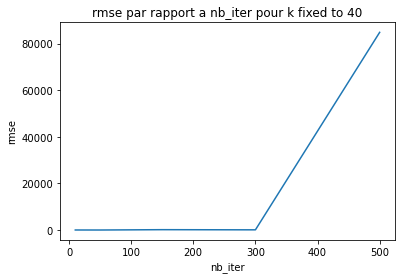

In [149]:
plt.plot(Nb_iter, Rmse_ALS_MV_Nb_iter)
plt.xlabel('nb_iter')
plt.ylabel('rmse')
plt.title('rmse par rapport a nb_iter pour k fixed to 40')
plt.show()